In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.cluster import hierarchy as hc
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
#-------------------------------------------
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
FigSize=(15,13)
FigSizeSmall=(10,8)

**In this notebook I am going to attempt to explore and build a simple logistic regression model on UCI Wine Dataset:**

Dua, D. and Karra Taniskidou, E. (2017). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.

### Data Import and Exploration:

In [2]:
data=pd.read_csv('./data/winedata.csv')

In [3]:
data.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
data.shape

(178, 14)

In [5]:
data.describe()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


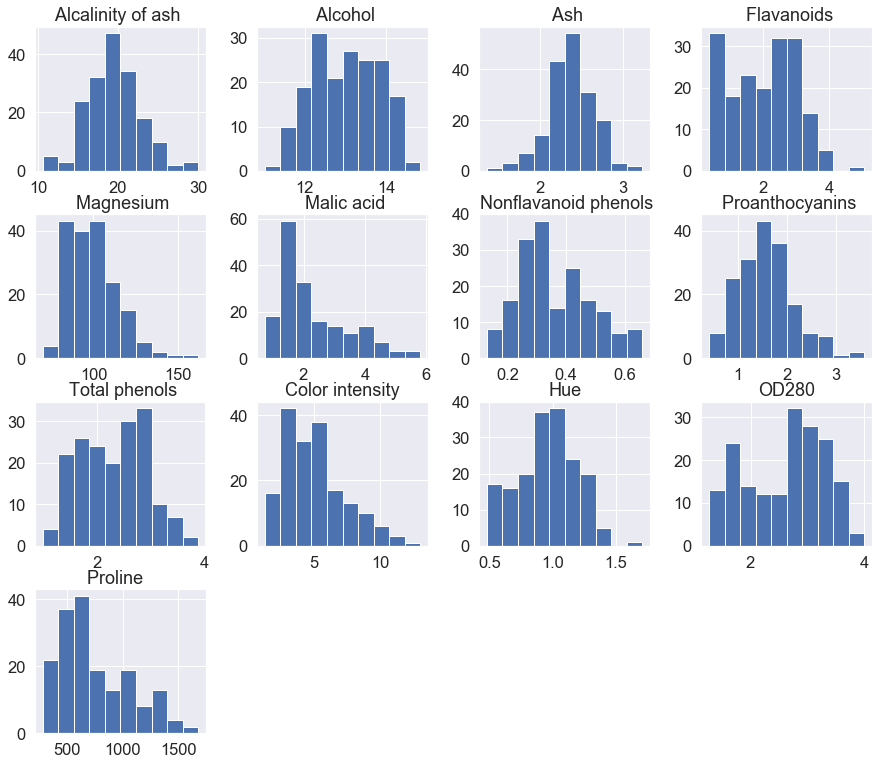

In [6]:
sns.set(font_scale=1.5);
data[data.columns[1:]].hist(figsize=FigSize);

By simply looking at the dataset we can observe some features like Malic acid is skewed. In the following snippet of code I attempt to calculate skewness and use log of features in the analysis. 

In [7]:
skewed_feats = data[data.columns[1:]].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[(skewed_feats > 0.75)|(skewed_feats <- 0.75) ] 
skewed_feats = skewed_feats.index
data[skewed_feats] = np.log1p(data[skewed_feats])

In [8]:
skewed_feats

Index([' Malic acid', ' Magnesium', 'Color intensity', 'Proline  '], dtype='object')

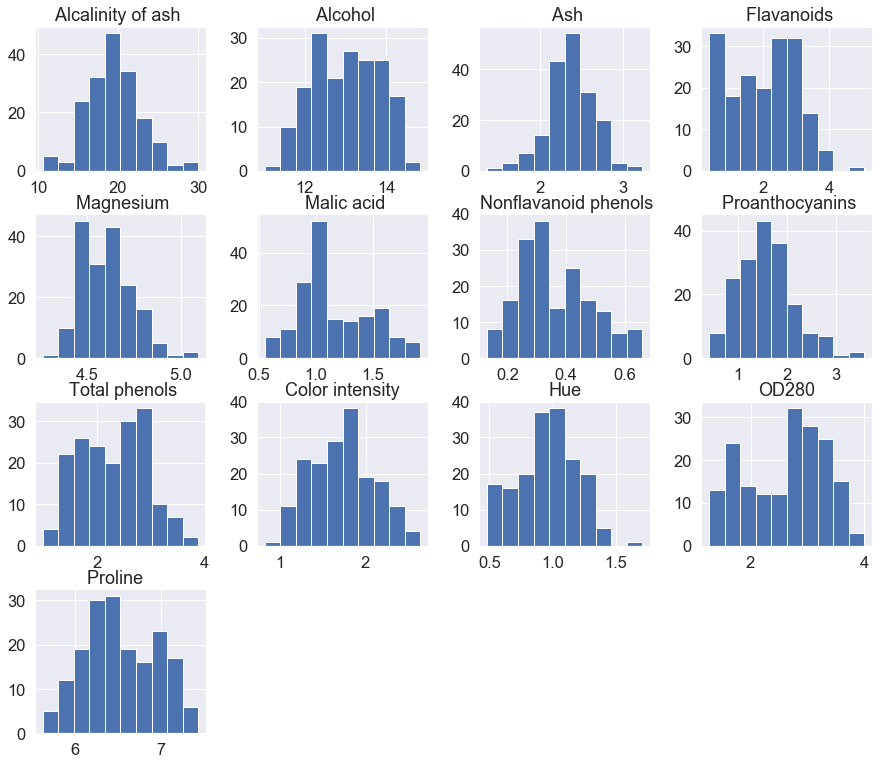

In [9]:
sns.set(font_scale=1.5);
data[data.columns[1:]].hist(figsize=FigSize);

There are 3 different classes of wines in the data as shown below.

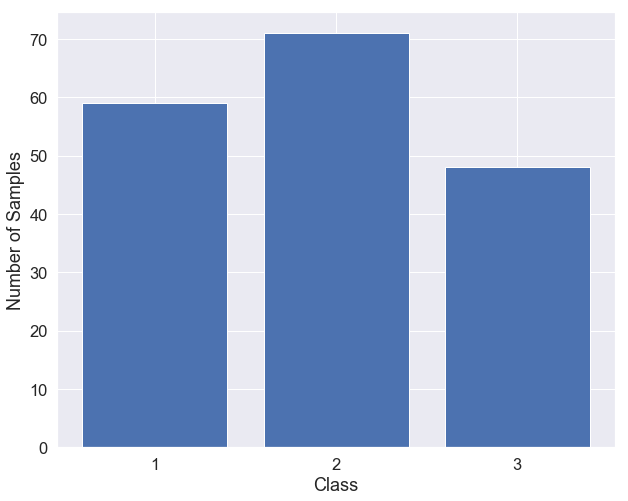

In [10]:
plt.figure(figsize=FigSizeSmall);
plt.bar(data['Class'].value_counts().index,list(data['Class'].value_counts()));
plt.xticks(data['Class'].value_counts().index, data['Class'].value_counts().index)
plt.ylabel('Number of Samples');
plt.xlabel('Class');

### Data Visualization

Box plot of the data shows ranges and mean of the data. As it can be seen Alcalinity of ash has widest range and parameters like Hue and Magnesium have lowest variability.

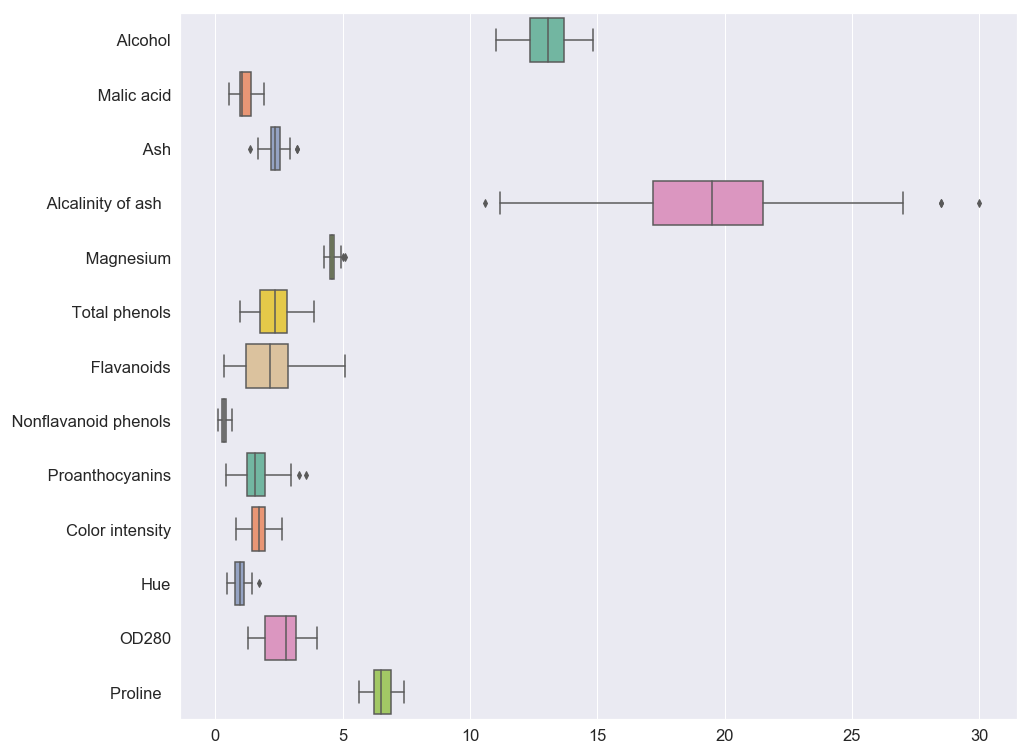

In [11]:
plt.figure(figsize=FigSize)
ax = sns.boxplot(data=data[data.columns[1:]], orient="h", palette="Set2")

Correlation heatmap shows correlations of different features with respect to each other. As it can be seen from the figure below, some parameters have high correlation together and several other parameters have poor correlation. Flavanoids and Total phenols for example have strong correlation. On the other hand, Nonflavanoid phenols and Malic acid have relatively poor correlation.      

In [12]:
def CorrelHeatmap(data,Meth,Title,FigSize):
    cmap = sns.diverging_palette(10, 150, as_cmap=True)
    sns.set(font_scale=1.5)
    corrmat = data.corr(method=Meth)
    mask = np.zeros_like(corrmat)
    mask[np.triu_indices_from(mask)] = True

    top_corr_features = corrmat.index
    plt.figure(figsize=FigSize)
    sns.heatmap(data.corr(method=Meth), annot=False, mask=mask,cmap=cmap,square=True, 
                                        xticklabels=True, yticklabels=True,
                                        linewidths=.5, cbar_kws={"shrink": .5})
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.title('Correlation: '+Meth+Title)
    plt.show()

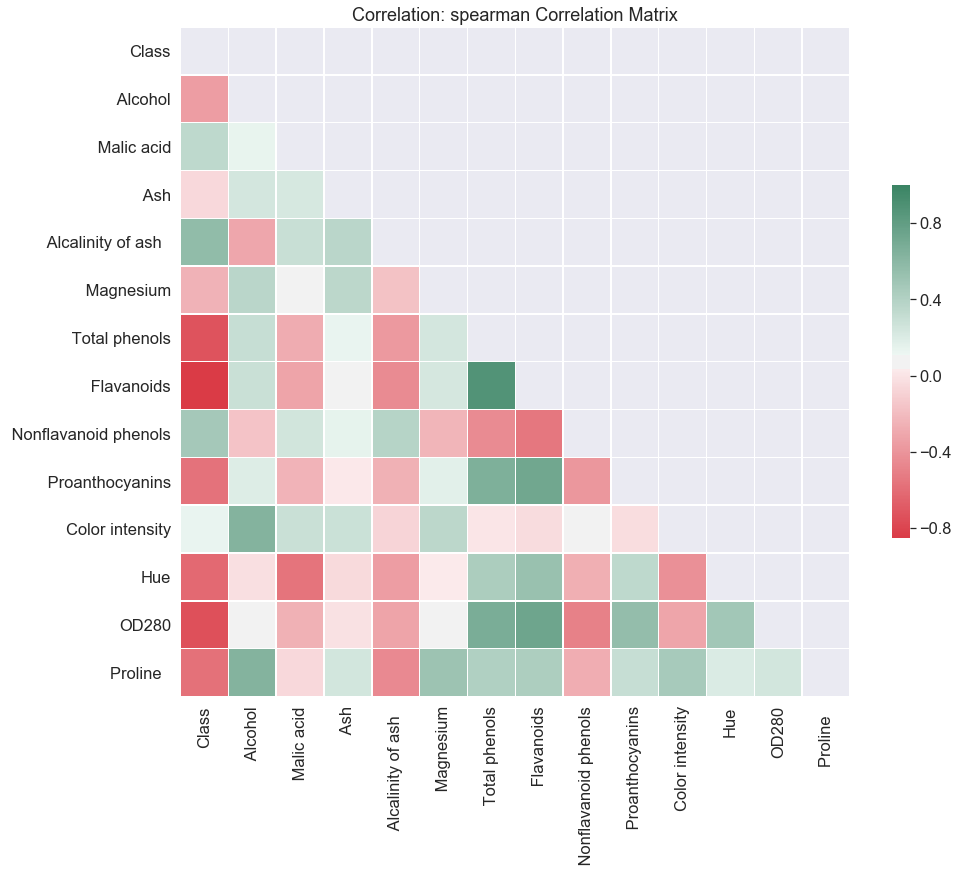

In [13]:
CorrelHeatmap(data,'spearman',' Correlation Matrix',FigSize)

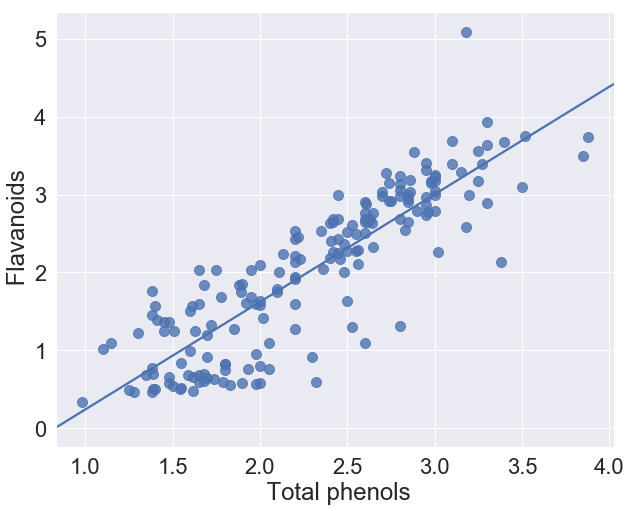

In [31]:
y_=' Flavanoids'
x_=' Total phenols'
sns.set(font_scale=2);
plt.figure(figsize=FigSizeSmall);
sns.regplot(y=y_,  x=x_, data=data,ci=None, scatter_kws={'s':100});

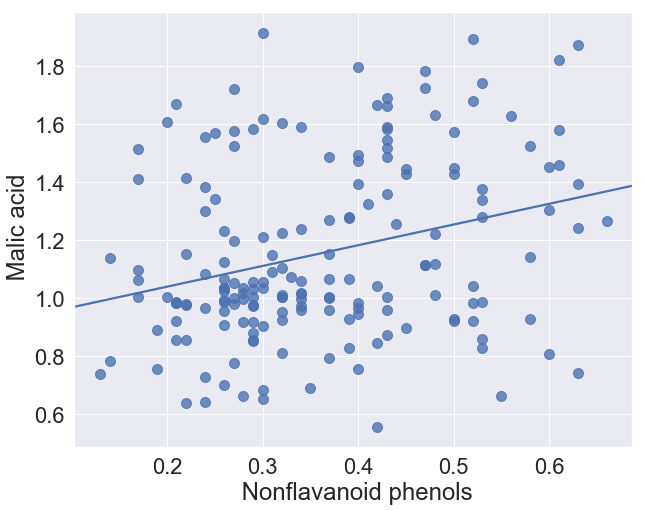

In [32]:
y_=' Malic acid'
x_=' Nonflavanoid phenols'
sns.set(font_scale=2);
plt.figure(figsize=FigSizeSmall);
sns.regplot(y=y_,  x=x_, data=data,ci=None, scatter_kws={'s':100});

Another way of visualizing high dimensional datasets is Dendrogram. This method is a hierarchical clustering that illustrates the arrangement of the clusters produced by the corresponding analyses. The vertical axis of the dendrogram represents the distance or dissimilarity between clusters. Each parameter has a stem or leaf, the shorter the stem the higher the correlation between parameters. Dendrogram for this database can be seen below.

In [15]:
def DendroGram(data,FigSize):
    plt.figure(figsize=FigSize)
    corr = 1 - data.corr() 
    sns.set(font_scale=2)
    corr_condensed = hc.distance.squareform(corr) # convert to condensed
    z = hc.linkage(corr_condensed, method='average')
    hc.dendrogram(z, labels=corr.columns,leaf_rotation=90)
    plt.xticks(fontsize=14 )
    plt.show()

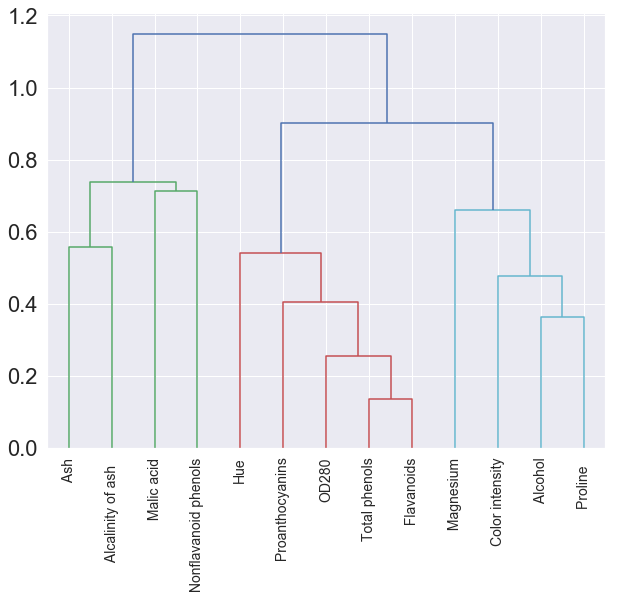

In [16]:
DendroGram(data[data.columns[1:]],FigSizeSmall)

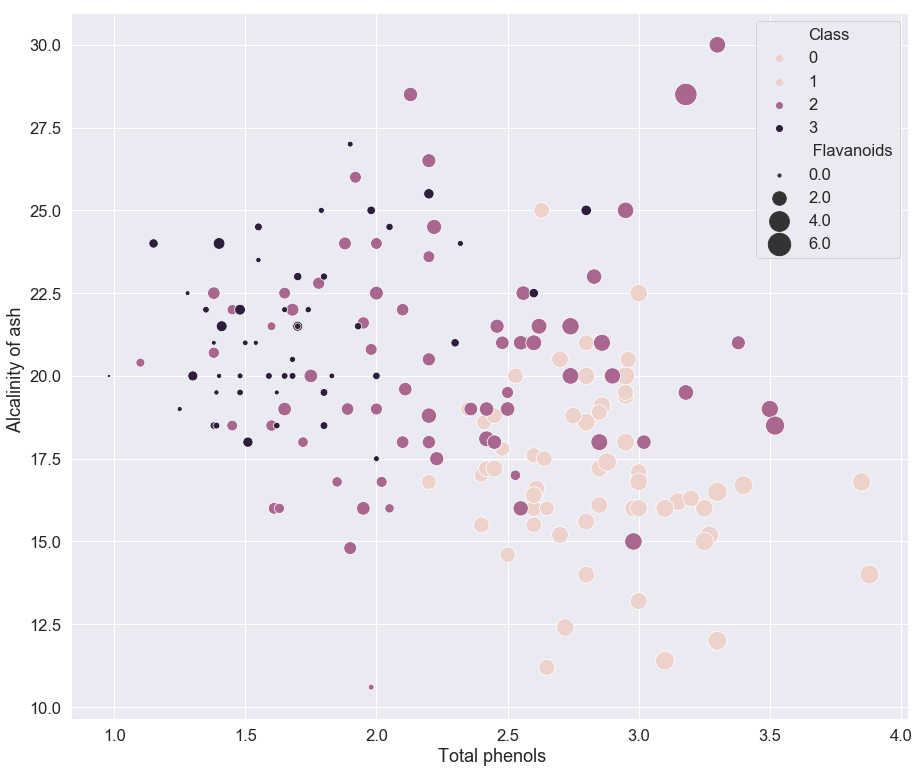

In [33]:
plt.figure(figsize=FigSize);
sns.set(font_scale=1.5);
sns.scatterplot(x=' Total phenols', y=' Alcalinity of ash  ',hue='Class', size=' Flavanoids', sizes=(10, 500),data=data);

### Modeling

**The task of the modeling of this dataset is classification.**  

KMeans is used to cluster the data into fixed number of clusters. First we change the number of clusters and identify sum of squared distance between clusters. As we can see, the number of clusters changed from 1 to 15 and sum of squared distance dropped from 2300 to less than 800. We are looking for optimal number of clusters that doesn’t put clusters either too far or too close together. For this task I have used 3 clusters  

In [19]:
X=data[data.columns[1:]]
y=data[data.columns[0]]
scaler=StandardScaler()
X=scaler.fit(X).transform(X)
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

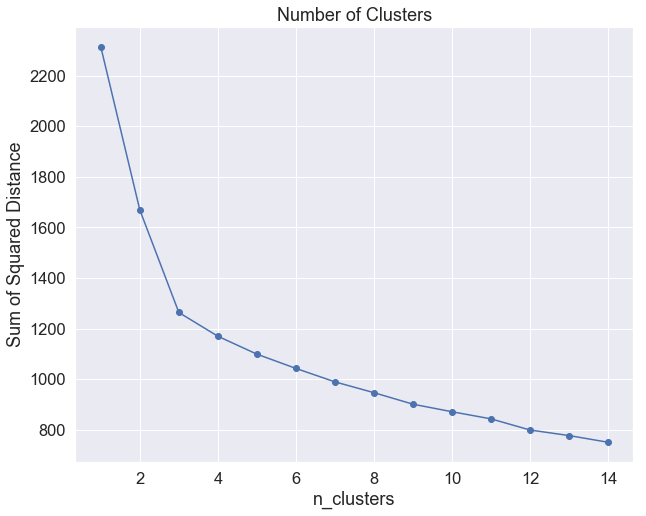

In [34]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.figure(figsize=FigSizeSmall)
plt.plot(K, Sum_of_squared_distances, 'bo-')
plt.xlabel('n_clusters')
plt.ylabel('Sum of Squared Distance')
plt.title('Number of Clusters')
plt.show()

We can see the result of Kmeans modeling below. Also studying average feature values of clusters can shed light on importance of features.

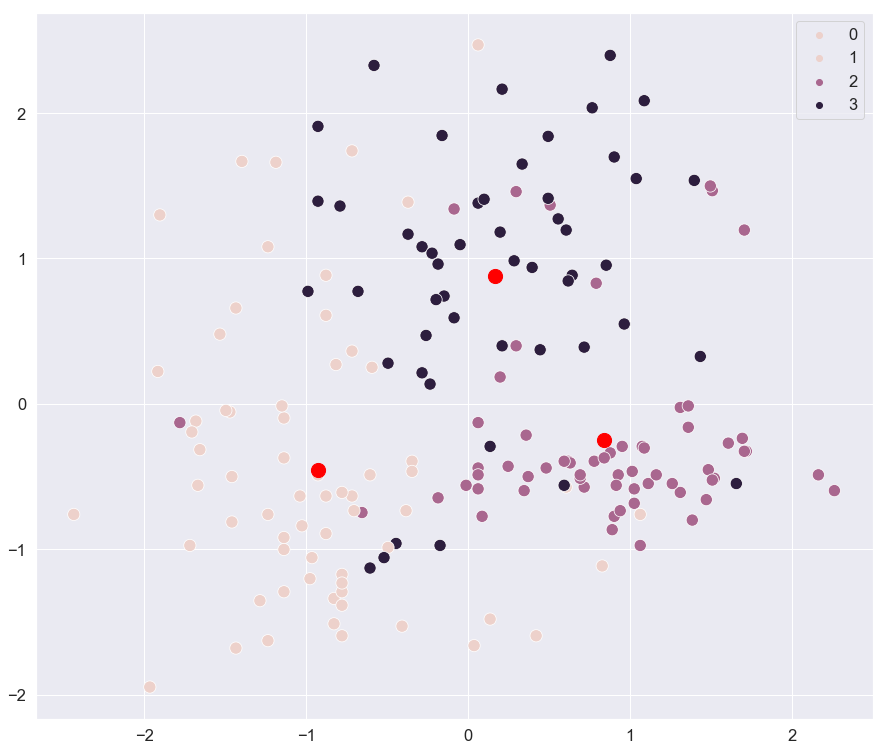

In [35]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
plt.figure(figsize=FigSize);
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=kmeans.predict(X)+1,s=150, cmap='viridis')
plt.legend()
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200);


In [22]:
Centroids=pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_))
Centroids.columns=data.columns[1:]
Centroids

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
0,12.250923,1.015406,2.231231,20.063077,4.531444,2.247692,2.050000,0.357692,1.624154,1.360573,1.062708,2.803385,6.198944
1,13.676774,1.078235,2.466290,17.462903,4.684429,2.847581,3.003226,0.292097,1.922097,1.844730,1.065484,3.163387,6.980422
2,13.134118,1.426063,2.417647,21.241176,4.595916,1.683922,0.818824,0.451961,1.145882,2.067925,0.691961,1.696667,6.410949


Finally we can build a logistic model to predict the class of wine based on Kmeans data. Since we have more than 2 classes we can use MNLogit model from statsmodels. 

In [26]:
X_train = sm.add_constant(X_train, prepend = False)
mdl = sm.MNLogit(list(y_train.values.ravel()), X_train)
mdl_fit = mdl.fit()

         Current function value: 0.000000
         Iterations: 35


C:\Users\Amir.Nejad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [27]:
mdl_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  119
Model:                        MNLogit   Df Residuals:                       91
Method:                           MLE   Df Model:                           26
Date:                Mon, 13 May 2019   Pseudo R-squ.:                   1.000
Time:                        16:22:35   Log-Likelihood:            -3.7630e-08
converged:                      False   LL-Null:                       -129.50
                                        LLR p-value:                 2.948e-40
==============================================================================
       y=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -17.7578   3.77e+05  -4.71e-05      1.000   -7.39e+05    7.39e+05
x2            -7.6589   8.65e+05  -8.85e-06      1.000    -1.7e+06     1.7e+06
x3           -13.7305   4.94e+05  -2.78e-05      1.000   -9.68e+05    9.68e+05
x4            15.8206    6.3e+05   2.51e-05      1.000   -1.24e+06    1.24e+06
x5            -3.2891    3.6e+05  -9.14e-06      1.000   -7.05e+05    7.05e+05
x6            -2.3536      1e+06  -2.34e-06      1.000   -1.97e+06    1.97e+06
x7            -0.1875   6.54e+05  -2.87e-07      1.000   -1.28e+06    1.28e+06
x8             1.3717   4.97e+05   2.76e-06      1.000   -9.74e+05    9.74e+05
x9             4.1786   4.78e+05   8.74e-06      1.000   -9.37e+05    9.37e+05
x10           -8.7390   8.99e+05  -9.72e-06      1.000   -1.76e+06    1.76e+06
x11           10.1997   6.95e+05   1.47e-05      1.000   -1.36e+06    1.36e+06
x12           -2.7263   9.23e+05  -2.95e-06      1.000   -1.81e+06    1.81e+06
x13          -24.5728   1.19e+06  -2.06e-05      1.000   -2.34e+06    2.34e+06
const          0.2293   4.85e+05   4.72e-07      1.000   -9.51e+05    9.51e+05
------------------------------------------------------------------------------
       y=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.1880   2.51e+06   1.27e-06      1.000   -4.91e+06    4.91e+06
x2            -2.3694   1.86e+06  -1.27e-06      1.000   -3.65e+06    3.65e+06
x3             3.0103   6.58e+06   4.58e-07      1.000   -1.29e+07    1.29e+07
x4             4.7460   3.48e+06   1.36e-06      1.000   -6.83e+06    6.83e+06
x5            -6.0355    1.6e+06  -3.78e-06      1.000   -3.13e+06    3.13e+06
x6             3.5863   1.94e+06   1.85e-06      1.000   -3.81e+06    3.81e+06
x7           -17.8441   8.15e+06  -2.19e-06      1.000    -1.6e+07     1.6e+07
x8            -4.0803   7.52e+05  -5.43e-06      1.000   -1.47e+06    1.47e+06
x9            -6.0502   2.87e+06  -2.11e-06      1.000   -5.62e+06    5.62e+06
x10            5.8658   2.73e+06   2.15e-06      1.000   -5.35e+06    5.35e+06
x11          -10.0251   2.52e+06  -3.97e-06      1.000   -4.95e+06    4.95e+06
x12          -10.6978    4.3e+06  -2.49e-06      1.000   -8.42e+06    8.42e+06
x13           -9.0196   1.94e+06  -4.64e-06      1.000   -3.81e+06    3.81e+06
const        -17.2820   6.67e+06  -2.59e-06      1.000   -1.31e+07    1.31e+07
==============================================================================
"""

In [28]:
X_test = sm.add_constant(X_test, prepend = False)
y_pred=np.argmax(mdl_fit.predict(X_test),axis=1)+1

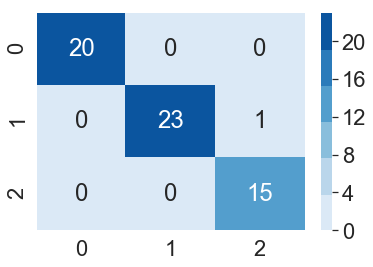

In [29]:
sns.heatmap(confusion_matrix(y_test, y_pred),cmap=sns.color_palette("Blues"),annot=True,);